In [2]:
import numpy as np
from imaging_methods import Imaging, Behavior, Experiment
from rastermap import Rastermap, utils
from scipy.stats import zscore

dff_path = '/Users/haotianli/Code/EngertLab/Data/image_data/lightsheet_cyto/dff_trace_20240605fish1spim1.npy'
frames_path = '/Users/haotianli/Code/EngertLab/Data/image_data/lightsheet_cyto/frames.npy'

swims1_path = '/Users/haotianli/Code/EngertLab/Data/image_data/lightsheet_cyto/swims1.npy'
swims2_path = '/Users/haotianli/Code/EngertLab/Data/image_data/lightsheet_cyto/swims2.npy'
gain_path = '/Users/haotianli/Code/EngertLab/Data/image_data/lightsheet_cyto/gain.npy'
grating_speed_path = '/Users/haotianli/Code/EngertLab/Data/image_data/lightsheet_cyto/grating_speed.npy'

imaging = Imaging(dff_path, frames_path)
behavior = Behavior(swims1_path, swims2_path, gain_path, grating_speed_path)
experiment = Experiment(imaging, behavior)

# spks = zscore(spks, axis=1)
dff = zscore(np.load(dff_path), axis=1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
model = Rastermap(n_clusters=100, # number of clusters to compute
                  n_PCs=200, # number of PCs to use
                  locality=0.1, # locality in sorting is low here to get more global sorting (this is a value from 0-1)
                  time_lag_window=5, # use future timepoints to compute correlation
                  grid_upsample=10, # default value, 10 is good for large recordings
                ).fit(dff)
y = model.embedding # neurons x 1
isort = model.isort

2025-08-03 21:26:48,067 [INFO] normalizing data across axis=1
2025-08-03 21:30:57,295 [INFO] projecting out mean along axis=0
2025-08-03 21:35:09,823 [INFO] data normalized, 518.67sec
2025-08-03 21:35:09,849 [INFO] sorting activity: 151066 valid samples by 17122 timepoints
2025-08-03 21:39:07,921 [INFO] n_PCs = 200 computed, 756.77sec
2025-08-03 21:40:47,025 [INFO] 100 clusters computed, time 855.88sec
2025-08-03 21:40:54,473 [INFO] clusters sorted, time 863.33sec
2025-08-03 21:40:55,692 [INFO] clusters upsampled, time 864.55sec
2025-08-03 21:42:32,744 [INFO] rastermap complete, time 961.60sec


In [5]:
nbin = 50 # number of neurons to bin over 
sn = utils.bin1d(dff[isort], bin_size=nbin, axis=0) # bin over neuron axis

In [17]:
# Deal with the frame-matching problem
frames_flag = np.load(frames_path)
print(frames_flag)
indices = np.where(frames_flag == 7000)
print(indices[0][0])

[    0.     0.     0. ... 17144. 17144. 17144.]
8842388


0.006953114140505689


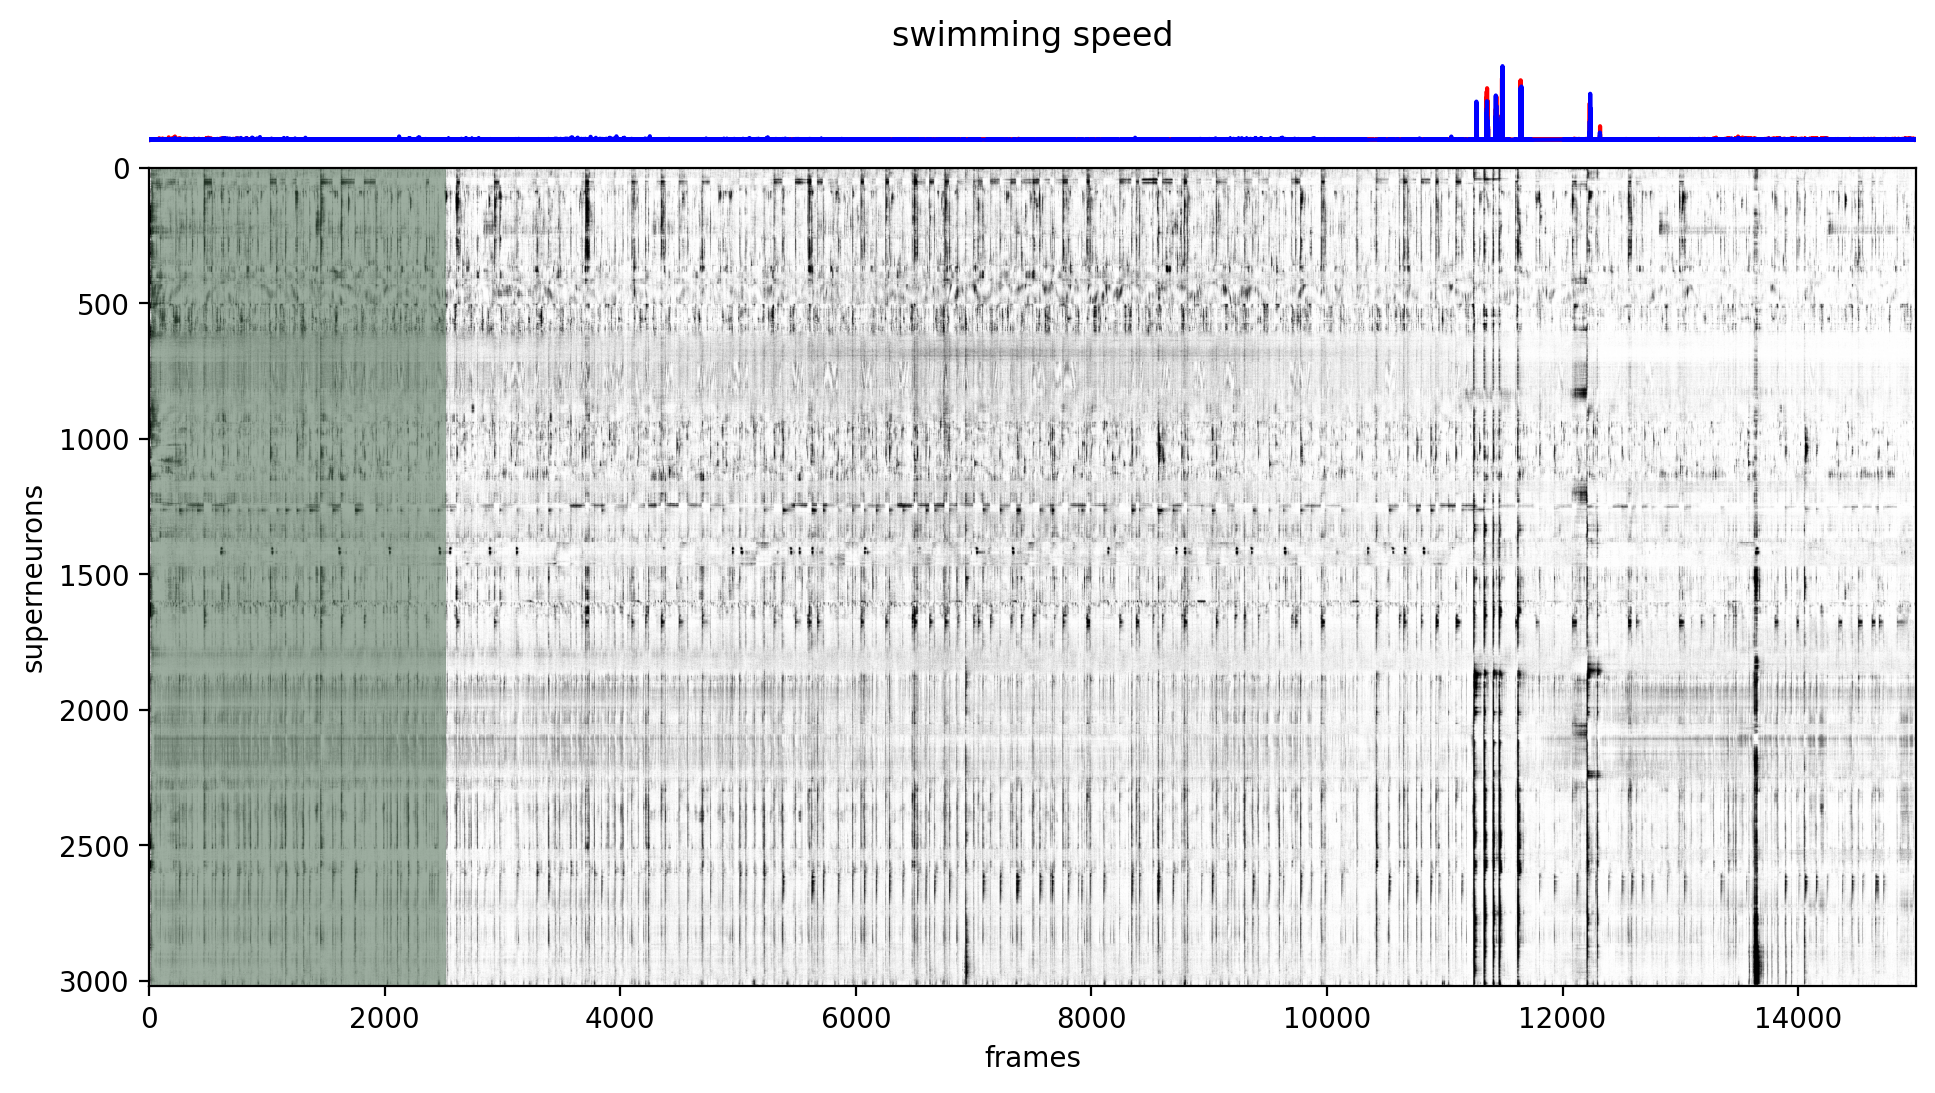

In [53]:
import matplotlib.pyplot as plt

# plt.style.use('dark_background')
plt.style.use('default')

# timepoints to visualize
xmin = 0
xmax = 3000
indices_min = np.where(frames_flag == xmin)[0][0]
indices_max = np.where(frames_flag == xmax)[0][0]

# make figure with grid for easy plotting
fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(9, 20, figure=fig, wspace = 0.05, hspace = 0.3)

swimming_1 = np.load(swims1_path)
swimming_2 = np.load(swims2_path)
# plot swimming speed
ax = plt.subplot(grid[0, :-1])
ax.plot(swimming_1[indices_min:indices_max], color='red')
ax.plot(swimming_2[indices_min:indices_max], color='blue')
ax.set_xlim([0, indices_max-indices_min])
ax.axis("off")
ax.set_title("swimming speed")

# plot superneuron activity
ax = plt.subplot(grid[1:, :-1])
ax.imshow(sn[:, xmin:xmax], cmap="gray_r", vmin=0, vmax=0.8, aspect="auto")
ax.set_xlabel("frames")
ax.set_ylabel("superneurons")

stims = np.load(gain_path)
# # color time periods by stimuli
from matplotlib import patches
nn = sn.shape[0]
stims_t = stims[indices_min:indices_max]
starts = np.nonzero(np.diff(stims_t))
# print(starts)
starts = np.append(np.array([0]), starts)
starts = np.append(starts, np.array([len(stims_t)-1]))
# print(starts)

frequency_ratio = dff.shape[0] / stims.shape[0]
print(frequency_ratio)

for n in range(len(starts)-1):
    start = starts[n]+1
    stype = stims_t[start]
    # print(stype)
    if np.isclose(stype, 0.1):
        color = '#3E5F44'
    elif np.isclose(stype, 0.05):
        color = '#5E936C'
    elif np.isclose(stype, 0.01):
        color = '#93DA97'
    elif np.isclose(stype, 0.0):
        color = '#77BEF0'
    else:
        color = '#799EFF'
    width = starts[n+1] - start + min(0, start)
    # print(width)
    start = max(0, start)
    ax.add_patch(
            patches.Rectangle(xy=(start, 0), width=width*frequency_ratio,
                        height=nn, facecolor=color, 
                        edgecolor=None, alpha=0.5))


# ax = plt.subplot(grid[1:, -1])
# ax.imshow(np.arange(0, len(sn))[:,np.newaxis], cmap="gist_ncar", aspect="auto")
# ax.axis("off")